In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import yaml
import cv2

sys.path.append('/home/schiavazza/code/hpe/')

from vicon_recordings.src.projection import C3dHelper

In [2]:
import matplotlib 
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","blue"])

In [3]:
file_path = '/home/schiavazza/data/hpe/vicon_recordings/EDPR_hpe/human_pose_estimation/P000/session/giovanna1.c3d'
c3d_helper = C3dHelper(file_path)

/home/schiavazza/code/hpe/vicon_recordings/venv/lib/python3.10/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


In [4]:
c3d_helper.calculate_frame_times()
frame = c3d_helper.get_frame_time(17.0 - 9.335795)

/home/schiavazza/code/hpe/vicon_recordings/src/projection.py:40: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, count = scipy.stats.mode(n_points)


In [5]:
vicon_dict = c3d_helper.get_points_dict(frame)

In [6]:
points_all = c3d_helper.get_points_frame(frame)

In [7]:
c3d_helper.points_labels
s = len(c3d_helper.points_labels)

In [8]:
with open("/home/schiavazza/code/hpe/vicon_recordings/data/points.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [9]:
image_points = data

In [10]:
image_points = np.ones((s, 3))
vicon_points = np.ones((s, 4))

In [11]:
k = 0
test = [None] * s
for i, l in enumerate(data):
    if l in c3d_helper.points_labels:
        print(l)
        test[k] = l
        p = data[l]
        image_points[k] = [p['x'], p['y'], 1.0]
        vicon_points[k][:3] = vicon_dict[l][:3]
        k += 1

print(test)
# image_points = np.flip(image_points, axis=0)

RASI
LASI
STRN
CLAV
RFHD
LFHD
LSHO
RSHO
['RASI', 'LASI', 'STRN', 'CLAV', 'RFHD', 'LFHD', 'LSHO', 'RSHO']


In [12]:
A = np.zeros((2*s, 12))
for i in range(s):
    A[2*i, :4] = vicon_points[i]
    A[2*i + 1, 4:8] = vicon_points[i]

    A[2*i, 8:] = vicon_points[i] * (-image_points[i][0])
    A[2*i+1, 8:] = vicon_points[i] * (-image_points[i][1])

In [13]:
print(A[:2])
print(vicon_points[0])
print(image_points[0])

print(vicon_points[0] * (-image_points[0][0]))

[[ 1.30921252e+03  2.25943579e+03  1.05525806e+03  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.85408330e+05 -4.92557002e+05 -2.30046256e+05 -2.18000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.30921252e+03  2.25943579e+03  1.05525806e+03  1.00000000e+00
  -2.90645180e+05 -5.01594746e+05 -2.34267289e+05 -2.22000000e+02]]
[1.30921252e+03 2.25943579e+03 1.05525806e+03 1.00000000e+00]
[218. 222.   1.]
[-2.85408330e+05 -4.92557002e+05 -2.30046256e+05 -2.18000000e+02]


In [14]:
points_colors = [cmap(i / s) for i in range(s)]

[218. 222.   1.]
[271. 222.   1.]
[241. 138.   1.]
[239. 123.   1.]
[237.  56.   1.]
[254.  59.   1.]
[273. 121.   1.]
[204. 121.   1.]


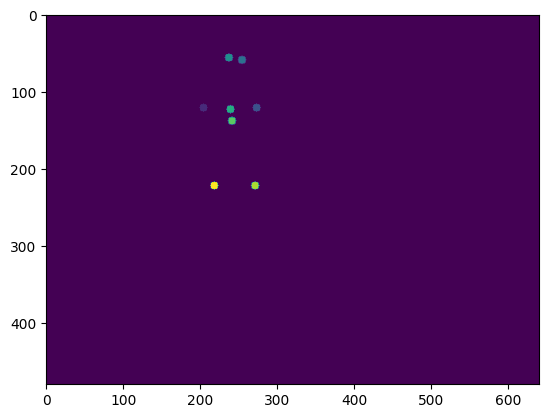

In [15]:
img = np.zeros((480, 640, 1))
for i, p in enumerate(image_points):
    print(p)
    cv2.circle(img, p[:2].astype(int), 5, np.asarray(points_colors[i]) * 255, -1)

plt.imshow(img)

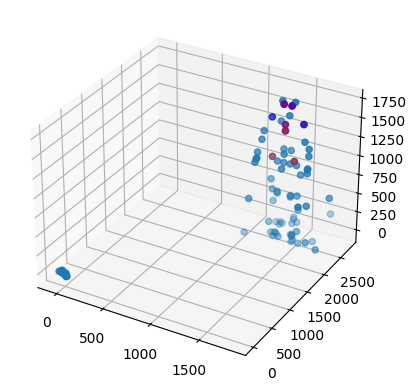

In [16]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(points_all[:, 0], points_all[:, 1], points_all[:, 2])
skel = ax.scatter(vicon_points[:,0], vicon_points[:, 1], vicon_points[:, 2], c=points_colors)

In [17]:
vicon_points[-1, :]

array([1.24358545e+03, 2.41627759e+03, 1.48565417e+03, 1.00000000e+00])

In [18]:
image_points[-1]

array([204., 121.,   1.])

[1309.21252441 2259.43579102 1055.25805664]
[1522.74694824 2298.13330078 1045.72766113]
[1414.48400879 2325.83349609 1396.96972656]
[1397.00720215 2368.69091797 1454.66723633]
[1390.81481934 2336.49389648 1727.92529297]
[1467.29467773 2350.33935547 1724.96691895]
[1558.17724609 2452.41650391 1476.43676758]
[1243.58544922 2416.27758789 1485.6541748 ]


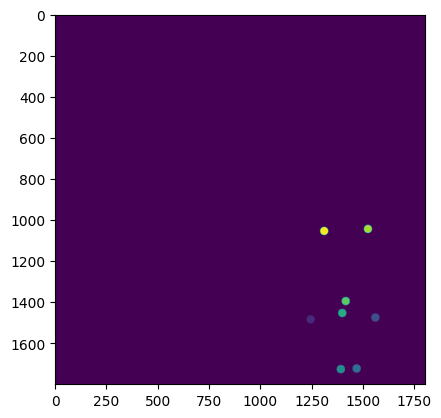

In [19]:
img = np.zeros((1800, 1800, 1))
for i, p in enumerate(vicon_points):
    print(p[:3])
    cv2.circle(img, (int(p[0]), int(p[2])), 20, np.asarray(points_colors[i])*255, -1)

plt.imshow(img)

In [20]:
# compute At x A
A_ = np.matmul(A.T, A)
# compute its eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(A_)
# find the eigenvector with the minimum eigenvalue
# (numpy already returns sorted eigenvectors wrt their eigenvalues)
m = eigenvectors[:, 11]

# reshape m back to a matrix
M = m.reshape(3, 4)

In [21]:
from scipy.optimize import minimize

def error(m):
    projected = (m.reshape(3, 4) @ vicon_points.transpose()).transpose()
    for r in projected:
        r /= r[-1]
    return (np.linalg.norm(image_points - projected, axis=1)).sum()

result = minimize(error, m)

In [22]:
x = result.x

In [23]:
P = x.reshape(3, 4)
print(P)

[[-1.95566827e-04 -4.33770853e-04  4.39125506e-05  9.97512323e-01]
 [ 2.68630869e-05 -2.48216754e-04  2.43766775e-04  7.04337996e-02]
 [ 1.78495313e-07 -1.81943934e-06  1.68539536e-07  2.81000292e-03]]


In [24]:
reconstructed_points = np.zeros((s, 2))
for i in range(s):
    r_image = (P @ vicon_points[i])
    r_image /= r_image[-1]
    print(f"image: {image_points[i]}\nreconstructed: {r_image}")
    reconstructed_points[i] = r_image[:2]

image: [218. 222.   1.]
reconstructed: [216.18243098 222.61978557   1.        ]
image: [271. 222.   1.]
reconstructed: [272.11047103 221.15297917   1.        ]
image: [241. 138.   1.]
reconstructed: [242.71936644 137.4455619    1.        ]
image: [239. 123.   1.]
reconstructed: [238.05888598 124.74403313   1.        ]
image: [237.  56.   1.]
reconstructed: [235.25243543  56.50973295   1.        ]
image: [254.  59.   1.]
reconstructed: [255.23845066  58.06726292   1.        ]
image: [273. 121.   1.]
reconstructed: [272.13620241 121.35709317   1.        ]
image: [204. 121.   1.]
reconstructed: [205.19190806 120.0887665    1.        ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[216.18243098 222.61978557]
[272.11047103 221.15297917]
[242.71936644 137.4455619 ]
[238.05888598 124.74403313]
[235.25243543  56.50973295]
[255.23845066  58.06726292]
[272.13620241 121.35709317]
[205.19190806 120.0887665 ]
[218. 222.   1.]
[271. 222.   1.]
[241. 138.   1.]
[239. 123.   1.]
[237.  56.   1.]
[254.  59.   1.]
[273. 121.   1.]
[204. 121.   1.]


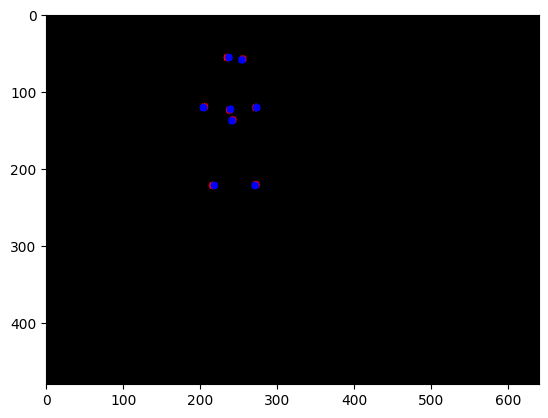

In [25]:
import cv2
img = np.zeros((480, 640, 3))
for i, p in enumerate(reconstructed_points):
    print(p)
    cv2.circle(img, p.astype(int), 5, (255, 0, 0), -1)

for i, p in enumerate(image_points):
    print(p)
    cv2.circle(img, p[:2].astype(int), 5, (0, 0, 255), -1)

plt.imshow(img)

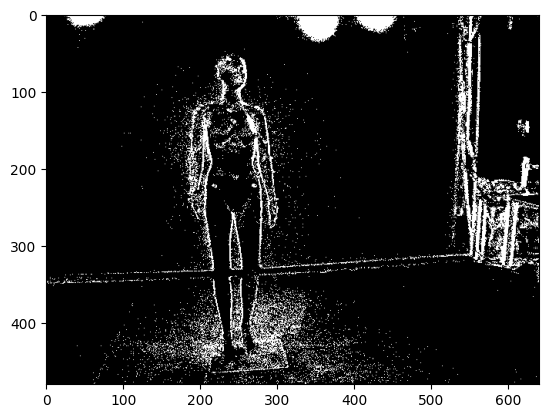

In [26]:
dvs_frame = cv2.imread('/home/schiavazza/code/hpe/vicon_recordings/data/frame.png')
points_to_transform = np.ones((points_all.shape[0], 4))
points_to_transform[:, :3] = points_all[:, :3]
plt.imshow(dvs_frame)

In [27]:
transformed_points = (P @ points_to_transform.transpose()).transpose()

In [28]:
# for i, p in enumerate(transformed_points):
#     # print(p)
#     x = int(p[0] / p[-1])
#     y = int(p[1] / p[-1])
#     cv2.circle(dvs_frame, (x, y), 5, (255, 0, 0), -1)


In [29]:
for i, p in enumerate(image_points[:]):
    ip = image_points[i]
    x = int(ip[0])
    y = int(ip[1])
    cv2.circle(dvs_frame, (x, y), 5, (255, 0, 0), -1)
    tp = reconstructed_points[i]
    # tx = int(tp[0] / tp[-1])
    # ty = int(tp[1] / tp[-1])
    tx = int(tp[0])
    ty = int(tp[1])
    cv2.circle(dvs_frame, (tx, ty), 5, (0, 0, 255), -1)

    cv2.line(dvs_frame, (x, y), (tx, ty), (0, 255, 0), 2)

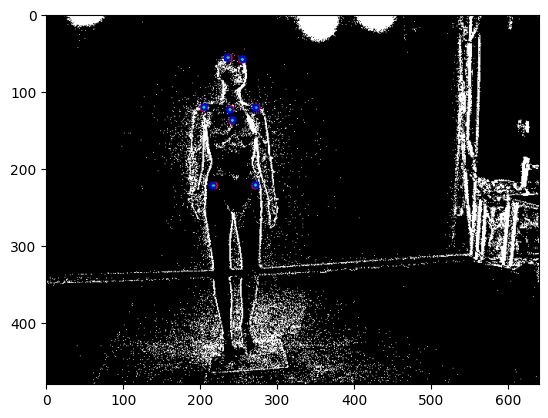

In [30]:
plt.imshow(dvs_frame)

In [31]:
reconstructed_points

array([[216.18243098, 222.61978557],
       [272.11047103, 221.15297917],
       [242.71936644, 137.4455619 ],
       [238.05888598, 124.74403313],
       [235.25243543,  56.50973295],
       [255.23845066,  58.06726292],
       [272.13620241, 121.35709317],
       [205.19190806, 120.0887665 ]])

In [32]:
decomposition = cv2.decomposeProjectionMatrix(P)

In [33]:
R = decomposition[0]
t = decomposition[1]

In [34]:
R

array([[ 2.37027349e-04,  3.15433170e-06, -4.14864139e-04],
       [ 0.00000000e+00,  2.19825941e-04, -2.70959578e-04],
       [ 0.00000000e+00,  0.00000000e+00, -1.83580544e-06]])

In [35]:
t

array([[-0.99522668, -0.09658737,  0.01132335],
       [ 0.00235487,  0.09246352,  0.99567989],
       [-0.09722357,  0.99095387, -0.09179471]])

[[-1.95566827e-04 -4.33770853e-04  4.39125506e-05  9.97512323e-01]
 [ 2.68630869e-05 -2.48216754e-04  2.43766775e-04  7.04337996e-02]
 [ 1.78495313e-07 -1.81943934e-06  1.68539536e-07  2.81000292e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-4.19878419e+03  7.09617033e+01  9.91347320e+05  1.39765199e+03]
 [-4.07494634e+02  4.26468729e+02 -5.10650379e+05  1.81137216e+03]
 [ 4.77723390e+01  4.52871576e+03 -6.29218764e+05  1.40147841e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


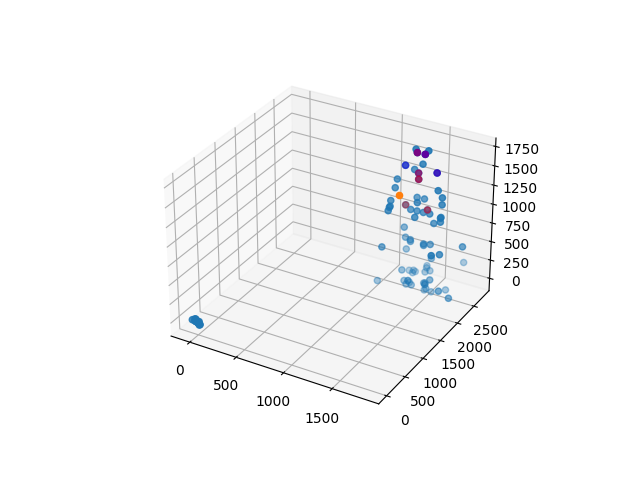

In [36]:
w_to_cam = np.zeros((4, 4))
w_to_cam[:3, :] = P
w_to_cam[-1, -1] = 1.0
print(w_to_cam)
cam_to_w = np.linalg.inv(w_to_cam)
print(cam_to_w)
cam_position = cam_to_w @ np.array([0.0, 0.0, 0.0, 1.0])
cam_position /= cam_position[-1]

%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(points_all[:, 0], points_all[:, 1], points_all[:, 2])
skel = ax.scatter(vicon_points[:,0], vicon_points[:, 1], vicon_points[:, 2], c=points_colors)

ax.scatter(cam_position[0], cam_position[1], cam_position[2])
all_p = np.ones((points_all.shape[0], 4))
all_p[:, :3] = points_all[:, :3]
test_points = (w_to_cam @ all_p.transpose()).transpose()
for p in test_points:
    p /= p[-1]

In [37]:
from vicon_recordings.src.projection import DvsHelper

In [38]:
dvs_helper = DvsHelper("/home/schiavazza/data/hpe/vicon_recordings/giovanna/1/")

9.335795, 9.335795
